In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images1/dl_img1.jpg
/kaggle/input/images1/dl_img2.jpg
/kaggle/input/2images/Francisco_Goya_10.jpg
/kaggle/input/2images/Paul_Klee_100.jpg


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from IPython.display import display as display_fn

2024-03-14 16:48:42.881386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 16:48:42.881493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 16:48:43.179782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define mean and standard deviation for normalization
vgg_mean = [0.485, 0.456, 0.406]
vgg_std = [0.229, 0.224, 0.225]

# Function to load and preprocess images with normalization
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))  # Resize for VGG19 and InceptionV3
    image = (image - vgg_mean) / vgg_std  # Normalize
    image = tf.expand_dims(image, axis=0)
    return image

In [4]:
# Function to display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [5]:
# Function to clip image pixel values
def clip_image_values(image, min_value=0.0, max_value=1.0):
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = tf.cast(tensor, tf.uint8)
    return tensor.numpy()

In [6]:
# Adjust the feature extraction models to use appropriate layers
def vgg_model():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(layer).output for layer in ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']]
    return tf.keras.Model(inputs=vgg.input, outputs=outputs)

In [7]:
def inception_model():
    inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    inception.trainable = False
    outputs = [inception.get_layer('conv2d_88').output]
    return tf.keras.Model(inputs=inception.input, outputs=outputs)

In [8]:
# Function to calculate content loss
def get_content_loss(content_targets, content_outputs):
    return tf.reduce_mean(tf.square(content_targets - content_outputs))

# Function to calculate style loss using Gram matrix
def get_style_loss(style_targets, style_outputs):
    loss = 0
    for target, output in zip(style_targets, style_outputs):
        gram_target = gram_matrix(target)
        gram_output = gram_matrix(output)
        loss += tf.reduce_mean(tf.square(gram_target - gram_output))
    return loss / len(style_targets)

# Function to calculate total variation loss
def get_total_variation_loss(image):
    return tf.image.total_variation(image)

In [9]:
# Function to compute the Gram matrix
def gram_matrix(input_tensor):
    num_channels = input_tensor.shape[-1]
    reshaped_tensor = tf.reshape(input_tensor, (-1, num_channels))
    gram = tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)
    return gram / tf.cast(tf.shape(reshaped_tensor)[0], tf.float32)

# Adjust the loss calculation to use appropriate layers and weights
def get_total_loss(style_targets, style_outputs, content_targets, content_outputs, generated_image, style_weight, content_weight, total_variation_weight):
    style_loss = get_style_loss(style_targets, style_outputs) * style_weight
    content_loss = get_content_loss(content_targets, content_outputs) * content_weight
    tv_loss = get_total_variation_loss(generated_image) * total_variation_weight
    total_loss = style_loss + content_loss + tv_loss
    return total_loss

In [10]:
# Function to run style transfer
def run_style_transfer(content_path, style_path, epochs=5, steps_per_epoch=100, content_weight=1e-5, style_weight=1e-4, total_variation_weight=1e-7):
    K.clear_session()

    # Load and preprocess images
    content_image = load_and_preprocess_image(content_path)
    style_image = load_and_preprocess_image(style_path)

    # Build the feature extraction models
    vgg_model_instance = vgg_model()
    inception_model_instance = inception_model()

    # Extract features
    style_features_style = vgg_model_instance(style_image)
    content_features_original = inception_model_instance(content_image)

    # Initialize generated_image before the loop
    generated_image = tf.Variable(content_image, dtype=tf.float32)

    # Use an appropriate optimizer (Adam is often a good choice)
    optimizer = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)

    # Prepare for saving intermediate results (optional)
    images = []
    
    # Initialize variables to store the final losses 
    final_style_loss = None
    final_content_loss = None
    final_tv_loss = None
    final_total_loss = None
    
    # Initialize lists to store losses
    style_losses = []
    content_losses = []
    tv_losses = []
    total_losses = []
    
    # Style transfer loop
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            with tf.GradientTape() as tape:
                # Extract features from the generated image
                style_features_generated = vgg_model_instance(generated_image)
                content_features_generated = inception_model_instance(generated_image)

                # Calculate losses
                #loss = get_total_loss(style_features_style, style_features_generated, content_features_original, content_features_generated, generated_image, style_weight, content_weight, total_variation_weight)
                loss = get_total_loss(style_features_style, style_features_generated, 
                                      content_features_original, content_features_generated, 
                                      generated_image, style_weight, content_weight, total_variation_weight)
                style_loss = get_style_loss(style_features_style, style_features_generated) * style_weight  
                content_loss = get_content_loss(content_features_original, content_features_generated) * content_weight
                tv_loss = get_total_variation_loss(generated_image) * total_variation_weight
                total_loss = style_loss + content_loss + tv_loss
                
                
                # Store losses
                style_losses.append(style_loss.numpy())
                content_losses.append(content_loss.numpy())
                tv_losses.append(tv_loss.numpy())
                total_losses.append(total_loss.numpy())
                
            # Calculate gradients
            gradients = tape.gradient(loss, generated_image)

            # Update image using the optimizer
            optimizer.apply_gradients([(gradients, generated_image)])

            # Clip pixel values to stay within the expected range
            generated_image.assign(clip_image_values(generated_image))

            # Visualize progress (optional)
            if (step + 1) % 50 == 0:
                display_image = tensor_to_image(generated_image[0])
                imshow(display_image, title=f"Epoch: {epoch + 1}, Step: {step + 1}")
                images.append(generated_image)
                
            # Store the final losses for the last step 
            if step == steps_per_epoch - 1:
                 final_style_loss = style_loss 
                 final_content_loss = content_loss
                 final_tv_loss = tv_loss
                 final_total_loss = loss 

    return generated_image, images, final_style_loss, final_content_loss, final_tv_loss, final_total_loss, style_losses, content_losses, tv_losses, total_losses

In [11]:
# Specify file paths
content_image_path = '/kaggle/input/2images/Francisco_Goya_10.jpg'
style_image_path = '/kaggle/input/2images/Paul_Klee_100.jpg'

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


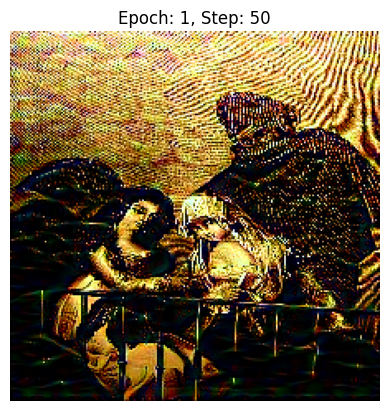

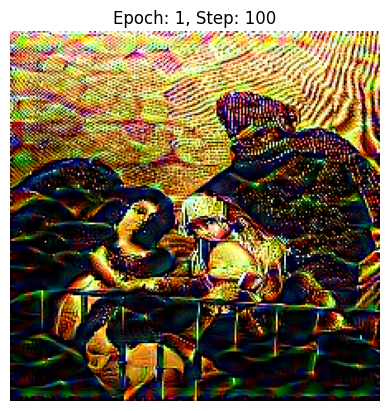

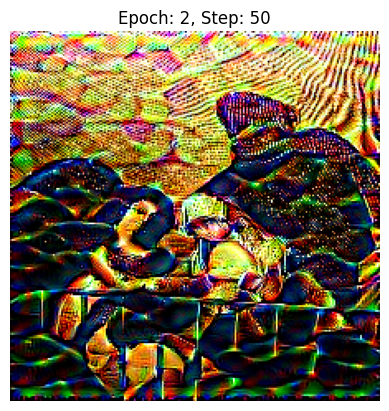

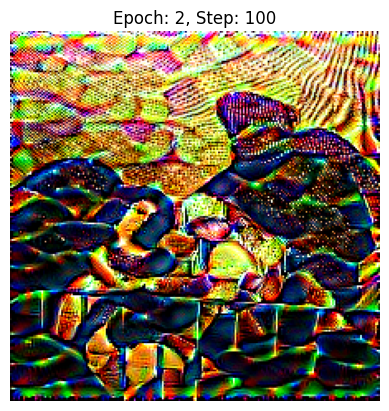

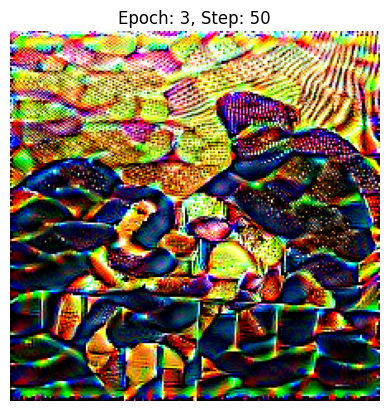

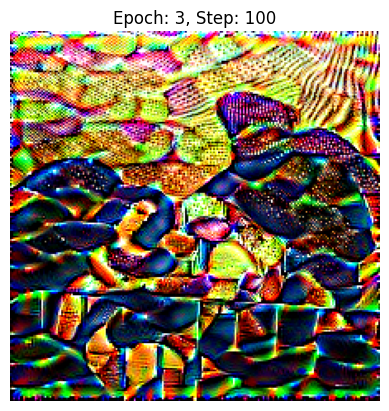

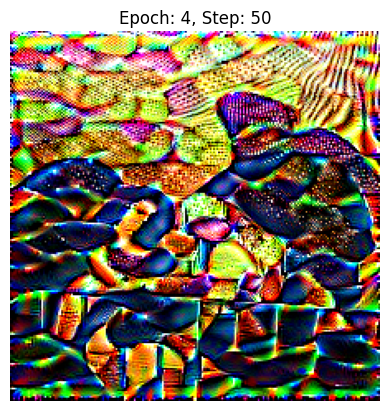

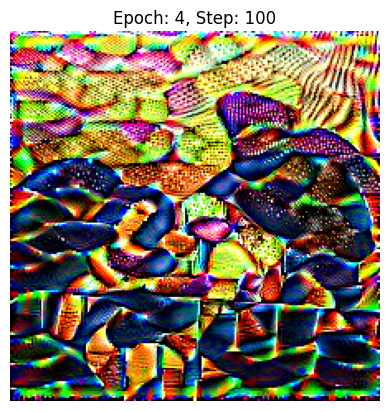

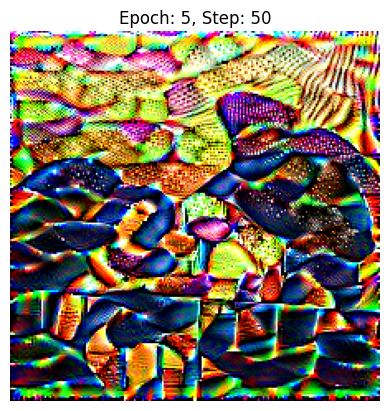

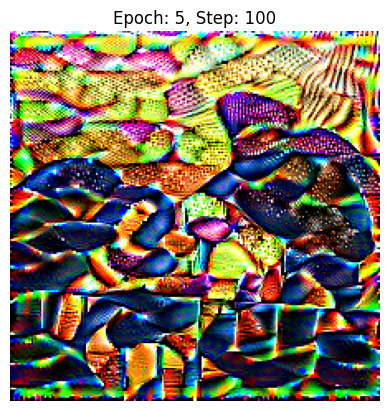

In [12]:
# Run style transfer
stylized_image, display_images, final_style_loss, final_content_loss, final_tv_loss, final_total_loss, style_losses, content_losses, tv_losses, total_losses = run_style_transfer(content_image_path, style_image_path)

In [13]:
# Print final metrics and losses
print("Final Metrics and Losses:")
print(f"Style Loss: {final_style_loss.numpy()}")
print(f"Content Loss: {final_content_loss.numpy()}")
print(f"Total Variation Loss: {final_tv_loss.numpy()}")
print(f"Total Loss: {final_total_loss.numpy()}")

Final Metrics and Losses:
Style Loss: 0.2683802843093872
Content Loss: 2.441299500333116e-07
Total Variation Loss: [0.00511473]
Total Loss: [0.27349526]


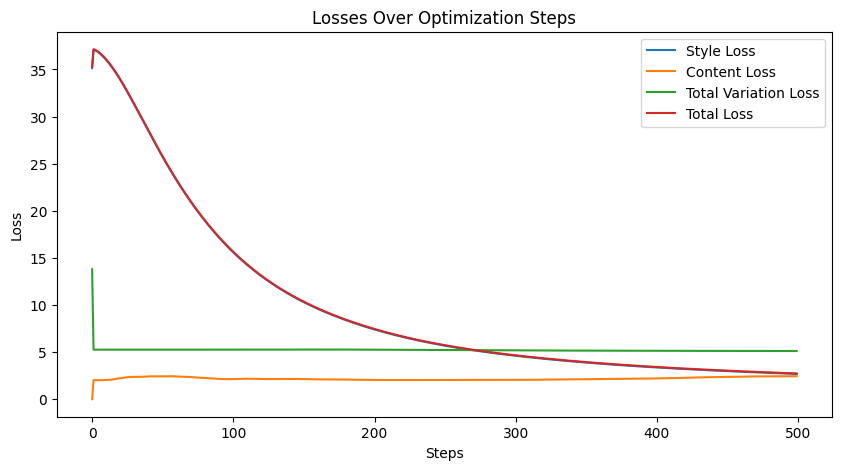

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(style_losses) * 10, label='Style Loss')  
plt.plot(np.array(content_losses) * 10000000, label='Content Loss')
plt.plot(np.array(tv_losses) * 1000, label='Total Variation Loss')
plt.plot(np.array(total_losses) * 10, label='Total Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Losses Over Optimization Steps')
plt.legend()
plt.show()

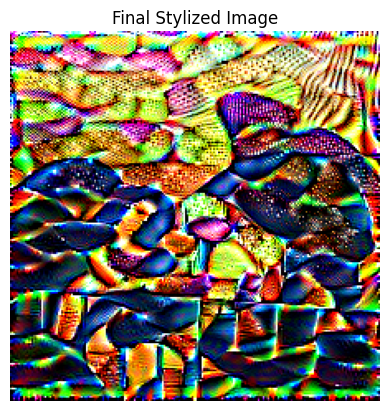

In [15]:
# Display the final stylized image
final_image = tensor_to_image(stylized_image[0])
imshow(final_image, title="Final Stylized Image")